### Homework C - Transformer network for video frame prediction ###

Create dataset of microscopy images

In [259]:
import deeptrack as dt
import numpy as np

IMAGE_SIZE = 64
sequence_length = 10  # Number of frames per sequence
MIN_SIZE = 0.5e-6
MAX_SIZE = 1.5e-6
MAX_VEL = 10  # Maximum velocity. The higher the trickier!
MAX_PARTICLES = 3  # Max number of particles in each sequence. The higher the trickier!

# Defining properties of the particles
particle = dt.Sphere(
    intensity=lambda: 10 + 10 * np.random.rand(),
    radius=lambda: MIN_SIZE + np.random.rand() * (MAX_SIZE - MIN_SIZE),
    position=lambda: IMAGE_SIZE * np.random.rand(2),
    vel=lambda: MAX_VEL * np.random.rand(2),
    position_unit="pixel",
)

# Defining an update rule for the particle position
def get_position(previous_value, vel):

    newv = previous_value + vel
    for i in range(2):
        if newv[i] > 63:
            newv[i] = 63 - np.abs(newv[i] - 63)
            vel[i] = -vel[i]
        elif newv[i] < 0:
            newv[i] = np.abs(newv[i])
            vel[i] = -vel[i]
    return newv


particle = dt.Sequential(particle, position=get_position)

# Defining properties of the microscope
optics = dt.Fluorescence(
    NA=1,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    magnification=10,
    resolution=(1e-6, 1e-6, 1e-6),
    wavelength=633e-9,
)

# Combining everything into a dataset.
# Note that the sequences are flipped in different directions, so that each unique sequence defines
# in fact 8 sequences flipped in different directions, to speed up data generation
sequential_images = dt.Sequence(
    optics(particle ** (lambda: 1 + np.random.randint(MAX_PARTICLES))),
    sequence_length=sequence_length,
)
dataset = sequential_images >> dt.FlipUD() >> dt.FlipDiagonal() >> dt.FlipLR()

In [260]:
print(np.shape(dataset.resolve()))

(10, 64, 64, 1)


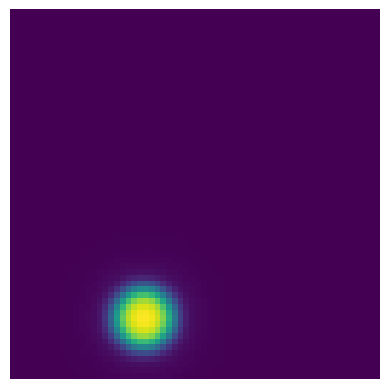

In [261]:
dataset.plot() # Plot first sequence

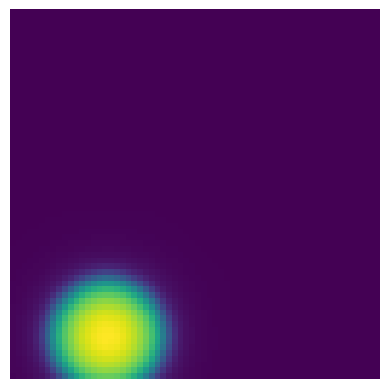

In [262]:
dataset.update().plot() # Plot updated sequence
video_sequence = dataset.update().resolve() # Get and store updated sequence

### Problem 1) Convolutional autoencoder ###

In [263]:
# Create dataset - training, validation and test
def create_dataset(train_len, val_len, test_len):
    train_data = []
    for i in range(train_len):
        train_data.extend(dataset.update().resolve())
    train_data = np.array(train_data)
    
    val_data = []
    for i in range(val_len):
        val_data.extend(dataset.update().resolve())
    val_data = np.array(val_data)
    
    test_data = []
    for i in range(test_len):
        test_data.extend(dataset.update().resolve())
    test_data = np.array(test_data)
    
    return train_data, val_data, test_data

train_data, val_data, test_data = create_dataset(train_len=1000, val_len=100, test_len=100)

In [ ]:
print(np.shape(train_data))
print(np.shape(val_data))
print(np.shape(test_data))

(10000, 64, 64, 1)
(1000, 64, 64, 1)
(1000, 64, 64, 1)


In [ ]:
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(64, 64, 1)), 
            # Encoder
            layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=2), # 64x64 -> 32x32
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2), 
            layers.Flatten(), # 2D -> 1D
            layers.Dense(latent_dim, activation='relu')
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Input(shape=(latent_dim,)),
            layers.Dense(8*8*16, activation='relu'),
            layers.Reshape((8, 8, 16)), # 1D -> 2D
            
            # Decoder
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(1, (3, 3), activation='linear', padding='same')
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

latent_dim = 128 # dimensions of the vector representation fed to decoder from encoder
autoencoder = Autoencoder(latent_dim=latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.encoder.summary()
autoencoder.decoder.summary()
        
        

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 32, 32, 64)        640       
                                                                 
 conv2d_51 (Conv2D)          (None, 16, 16, 32)        18464     
                                                                 
 conv2d_52 (Conv2D)          (None, 8, 8, 16)          4624      
                                                                 
 flatten_14 (Flatten)        (None, 1024)              0         
                                                                 
 dense_29 (Dense)            (None, 128)               131200    
                                                                 
Total params: 154,928
Trainable params: 154,928
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_27"
________________________

Train the autoencoder 

In [ ]:
autoencoder.fit(x=train_data, y=train_data, epochs=10, shuffle=True, validation_data=(val_data, val_data))

Epoch 1/10
 14/313 [>.............................] - ETA: 2:38 - loss: 0.0416

KeyboardInterrupt: 

Visualize results

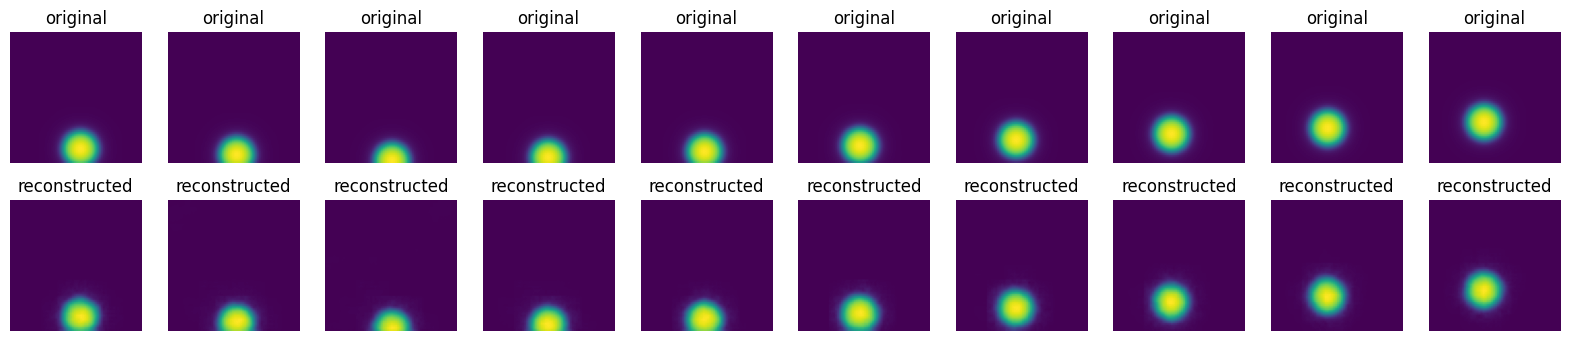

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

encoded_images = autoencoder.encoder(test_data).numpy()
decoded_images = autoencoder.decoder(encoded_images).numpy()

n_images = 10
plt.figure(figsize=(20, 4))
for i in range(n_images): # plot original and reconstructed images for first sequence    
    ax = plt.subplot(2, n_images, i + 1) # original images
    plt.title("original")
    plt.imshow(tf.squeeze(test_data[i]))
    plt.axis("off")
    
    bx = plt.subplot(2, n_images, i+n_images+1) # reconstructed images
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_images[i]))
    plt.axis("off")
plt.show()

### Problem 2) Transformer encoder ###

Construct time embedding layer

In [ ]:
Layer = tf.keras.layers.Layer

class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len
        
        def build(self, input_shape):
            self.weights_linear = self.add_weight(name='weight_linear',
                                                  shape = (int(self.seq_len),),
                                                  initializer = 'uniform',
                                                  trainable = True)
            
            self.bias_linear = self.add_weight(name='bias_linear',
                                               shape = (int(self.seq_len),),
                                               initializer = 'uniform',
                                               trainable = True)
            
            self.weights_periodic = self.add_weight(name='weight_periodic',
                                                    shape = (int(self.seq_len),),
                                                    initializer = 'uniform',
                                                    trainable = True)
            
            self.bias_periodic = self.add_weight(name='bias_periodic',
                                                 shape = (int(self.seq_len),),
                                                 initializer = 'uniform',
                                                 trainable = True)
            
            def call(self, x):
                x = tf.math.reduce_mean(x[:,:,:], axis=-1) # Convert (batch, seq_len, 64, 64, 1) to (batch, seq_len, 64, 64)
                time_linear = self.weights_linear * x + self.bias_linear # Linear part of the model
                time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension for concatenation
                
                time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic) # Periodic part of the model
                time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension for concatenation
                
                return tf.concat([time_linear, time_periodic], axis=-1) # (batch, seq_len, 64, 64, 2)
            

Construct Transformer decoder with multi-head attention

In [ ]:
from tensorflow.keras.layers import MultiHeadAttention, Dropout, LayerNormalization, Conv1D, Dense

class TransformerEncoder(Layer):
    def __init__(self, d_k, d_v, n_heads, ff_dim, dropout_rate, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        
        def build(self, input_shape):
            self.attn = MultiHeadAttention(num_heads=self.n_heads, query_dim=self.d_k, key_dim=self.d_k,
                                           value_dim=self.d_v, dropout=self.dropout_rate)
            
            self.dropout_1 = Dropout(self.dropout_rate)
            self.norm_1 = LayerNormalization(epsilon=1e-6)
            self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
            self.ff_conv1D_2 = Conv1D(filters=self.d_k, kernel_size=1) 
            # self.ff_conv1D_2 = Conv1D(filters=self.ff, kernel_size=1) 
            
            # self.dense_1 = Dense(self.ff_dim, activation='relu')
            # self.dense_2 = Dense(self.d_k, activation='relu')
            self.norm_2 = LayerNormalization(epsilon=1e-6)
            
        def call(self, inputs):
            attn = self.attn(inputs, inputs, inputs)
            attn = self.dropout_1(attn)
            attn = self.norm_1(inputs + attn)
            
            ff = self.ff_conv1D_1(attn)
            ff = self.ff_conv1D_2(ff)
            ff = self.dropout_2(ff)
            ff = self.norm_2(inputs + ff)
            
            return ff

In [ ]:
from tensorflow.keras.layers import Input, Concatenate, GlobalAveragePooling1D, Dense

# Do not train the decoder
autoencoder.decoder.trainable = False
autoencoder.encoder.trainable = False


seq_len = 9 
d_k = latent_dim + 2
d_v = latent_dim + 2
ff_dim = latent_dim + 2
n_heads = 12
dropout_rate = 0.2

def create_model(latent_dim):
    time_embedding = Time2Vector(seq_len)
    attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim, dropout_rate)
    attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim, dropout_rate)
    attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim, dropout_rate)
    
    input_seq = Input(shape=(seq_len, latent_dim))
    x = time_embedding(input_seq)
    x = Concatenate(axis=-1)([input_seq, x])
    x = attn_layer1(x)
    x = attn_layer2(x)
    x = attn_layer3(x)
    x = GlobalAveragePooling1D()(x)
    
    x = Dropout(dropout_rate)(x)
    x = Dense(latent_dim, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(latent_dim, activation='linear')(x)
    out = Dense(latent_dim, activation='linear')(x)
    
    model = Model(inputs=input_seq, outputs=out)
    model.compile(optimizer='adam', loss='mse')
    return model

model = create_model(latent_dim)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_81 (InputLayer)          [(None, 9, 128)]     0           []                               
                                                                                                  
 time2_vector_53 (Time2Vector)  (None, 9, 128)       0           ['input_81[0][0]']               
                                                                                                  
 concatenate_50 (Concatenate)   (None, 9, 256)       0           ['input_81[0][0]',               
                                                                  'time2_vector_53[0][0]']        
                                                                                                  
 transformer_encoder_108 (Trans  (None, 9, 256)      0           ['concatenate_50[0][0]']   

Create dataset

In [ ]:
train_pictures = []
train_len = 2000
for i in range(train_len):
  train_pictures.extend(dataset.update().resolve())
train_pictures = np.array(train_pictures)

val_pictures = []
val_len = 200
for i in range(val_len):
  val_pictures.extend(dataset.update().resolve())
val_pictures = np.array(val_pictures)  

# The aim is to train frame prediction, so we remove tenth frame from each sequence
train_frames, train_targets = tf.split(train_pictures, [9, 1], axis=1)
val_frames, val_targets = tf.split(val_pictures, [9, 1], axis=1)

# encode the frames using the encoder part of the autoencoder
train_sequences = []
for i in range(train_len):
  train_sequences.append(autoencoder.encoder(train_frames[i]))
  
val_sequences = []
for i in range(val_len):
  val_sequences.append(autoencoder.encoder(val_frames[i]))

# Verify data shapes
print("Train frames shape:", train_frames.shape)
print("Train targets shape:", train_targets.shape)
print("Train sequences shape:", np.array(train_sequences).shape)
print("Val frames shape:", val_frames.shape)
print("Val targets shape:", val_targets.shape)
print("Val sequences shape:", np.array(val_sequences).shape)

Construct attention layers manually

In [ ]:
from tensorflow.keras.layers import Dense

class SingleAttention(Layer):
    def __init__(self, d_k, d_v):
        super(SingleAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        
    def build(self, input_shape):
        self.query = Dense(self.d_k, input_shape=input_shape, 
                           kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
        
        self.key = Dense(self.d_k, input_shape=input_shape,
                         kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
        
        self.value = Dense(self.d_v, input_shape=input_shape,
                           kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
        
    def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
        q = self.query(inputs[0])
        k = self.key(inputs[1])
        
        attn_weights = tf.matmul(q, k, transpose_b=True)
        attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
        attn_weights = tf.nn.softmax(attn_weights, axis=-1)
        
        v = self.value(inputs[2])
        attn_out = tf.matmul(attn_weights, v)
        return attn_out

In [ ]:
class MultiAttention(Layer): # multi-head attention
    def __init__(self, d_k, d_v, h, d_model):
        super(MultiAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = h
        self.d_model = d_model
        self.attn_heads = list()
        
    def build(self, input_shape):
            for n in range(self.n_heads):
                self.attn_heads.append(SingleAttention(self.d_k, self.d_v))
                
            self.linear = Dense(self.d_model, input_shape=input_shape,
                                kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    
    def call(self, inputs):
        print("MultiAttention layer")
        attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)] 
        print("attn list calculated")
        print("attn shape: ", len(attn), attn[0].shape)
        concat_attn = tf.concat(attn, axis=-1)
        print("concat_attn shape: ", concat_attn.shape)
        multi_linear = self.linear(concat_attn)
        print("multi_linear shape: ", multi_linear.shape)
        return multi_linear
            

In [ ]:
from tensorflow.keras.layers import Conv1D, LayerNormalization, Dropout

class TransformerEncoder(Layer): # Combining all layers into an encoder
    def __init__(self, d_k, d_v, h, d_model, ff_dim, dropout_rate=0.2, **kwargs):
        super(TransformerEncoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.num_heads = h
        self.d_model = d_model
        self.ff_dim = ff_dim
        self.attn_heads = list()
        self.dropout_rate = dropout_rate
        
    def build(self, input_shape):
        self.attn_multi = MultiAttention(self.d_k, self.d_v, self.num_heads, self.d_model)
        self.attn_dropout = Dropout(rate=self.dropout_rate)
        self.attn_normalize = LayerNormalization(input_shape=input_shape)
        
        self.ff_1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
        self.ff_1D_2 = Conv1D(filters=self.d_model, kernel_size=1) 
        self.ff_dropout = Dropout(rate=self.dropout_rate)
        self.ff_normalize = LayerNormalization(input_shape=input_shape)

    def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
        print('TransformerEncoder layer')
        attn = self.attn_multi(inputs) 
        print("attn (pre-normalize) shape: ", attn.shape)
        attn = self.attn_dropout(attn) 
        print("inputs shape: ", inputs[0].shape)
        attn = self.attn_normalize(inputs[0] + attn) 
        print("attn shape (post-normalize): ", attn.shape)
        
        ff = self.ff_1D_1(attn)
        ff = self.ff_1D_2(ff)
        ff = self.ff_dropout(ff)
        ff = self.ff_normalize(inputs[0] + ff)
        return ff

Create the transformer network

In [ ]:
from tensorflow.keras.layers import Input, Concatenate, GlobalAveragePooling1D, Dense

seq_len = 9 
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

def create_model(latent_dim):
    d_model = latent_dim + 2 # 2 for time encoding
    # Initialize time and multi-head attention layers
    time = Time2Vector(seq_len)
    attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, d_model, ff_dim)
    attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, d_model, ff_dim)
    
    # construct model
    input_seq = Input(shape=(seq_len, latent_dim))
    print("input_seq shape:", input_seq.shape) ## REMOVE
    x = time(input_seq) 
    print("time shape:", x.shape) ## REMOVE
    x = Concatenate(axis=-1)([input_seq, x])
    print("concat shape:", x.shape) ## REMOVE
    x = attn_layer1((x, x, x))
    x = attn_layer2((x, x, x))
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    
    out = Dense(1, activation='linear')(x)
    
    model = Model(input_seq, out)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    
    return model

In [ ]:
latent_dim = 128
model = create_model(latent_dim)

model.summary()

input_seq shape: (None, 9, 128)
time shape: (None, 9, 128)
concat shape: (None, 9, 256)
TransformerEncoder layer
MultiAttention layer
attn list calculated
attn shape:  12 (None, 9, 256)
concat_attn shape:  (None, 9, 3072)
multi_linear shape:  (None, 9, 130)
attn (pre-normalize) shape:  (None, 9, 130)
inputs shape:  (None, 9, 256)


ValueError: Exception encountered when calling layer "transformer_encoder_100" (type TransformerEncoder).

in user code:

    File "C:\Users\jespe\AppData\Local\Temp\ipykernel_11804\1960854374.py", line 30, in call  *
        attn = self.attn_normalize(inputs[0] + attn)

    ValueError: Dimensions must be equal, but are 256 and 130 for '{{node transformer_encoder_100/add}} = AddV2[T=DT_FLOAT](Placeholder, transformer_encoder_100/dropout/Identity)' with input shapes: [?,9,256], [?,9,130].


Call arguments received by layer "transformer_encoder_100" (type TransformerEncoder):
  • inputs=('tf.Tensor(shape=(None, 9, 256), dtype=float32)', 'tf.Tensor(shape=(None, 9, 256), dtype=float32)', 'tf.Tensor(shape=(None, 9, 256), dtype=float32)')